### 1) Overall configurations 

In [1]:
import os
import os.path
import pandas as pd
from pprint import pprint

# Example large data
instance_settings_path = "C:/Users/LocalAdmin/IdeaProjects/slevels/src/main/resources/week/profile_time.json"

### 2) Loading the instance data

In [2]:
import json

def load_json(path):
    """Read json file and return dictionary"""

    # Add .json to the end of file if needed
    if path.find(".json") < 0:
        path = path + ".json"

    # Read JSON file
    with open(path) as data_file:
        data_loaded = json.load(data_file)

    return data_loaded

instances_dic = load_json(instance_settings_path)

# Folder where results will be saved
result_folder = instances_dic["result_folder"]
request_log_folder = result_folder + "/request_track"
violin_log_folder = result_folder + "violin_plot/"

# Folder where instances are located
instances_folder = instances_dic["instances_folder"]

# File name aggregated data
instance_name = instances_dic["instance_name"]


print("########### INSTANCE SETTINGS ##################################################")
pprint(instances_dic)

########### INSTANCE SETTINGS ##################################################
{'adjacency_matrix_file': 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/data/out/manhattan_nyc/distance/adjacency_matrix.csv',
 'distances_file': 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/data/out/manhattan_nyc/distance/dist_matrix_m.csv',
 'instance_description': 'Parallel vs. Sequential execution - update fleet '
                         'status',
 'instance_name': 'S1',
 'instances_folder': 'C:/Users/LocalAdmin/IdeaProjects/slevels/instance_output/profile_time/',
 'labels': {'BA': 'batch_duration',
            'CD': 'contract_duration',
            'CS': 'customer_segmentation',
            'CT': 'clear_target_list_every_round',
            'HE': 'heuristic_rebalancing',
            'ID': 'instance_description',
            'IF': 'initial_fleet',
            'IN': 'instance_name',
            'MC': 'max_capacity',
            'MO': 'allow_many_to_one',

### Violin plot (MET X UNMET and Initial X Third-party fleet)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.despine(left=True)

def violin(df_user_track, violin_log_folder, file_name, replace=False, file_extension = 'pdf'):
    
    font_ticks = 16
    font_axis = 18
    font_title = 20
    # Create directory
    if not os.path.exists(violin_log_folder):
        os.makedirs(violin_log_folder)
    
    output_file_name = "{}{}.{}".format(violin_log_folder, file_name, file_extension)
    
    # Stop generation if already generated 
    if os.path.isfile(output_file_name) and not replace:
        return
    
    
    # New column labels (variable names are column names)
    service_level = "Pickup deadline"
    service = "User serviced by" 
    sq_class = "SQ Class"
    pk_delay = "Pickup delay (min)"
    
    # New data nomenclature
    dic_sq_class = {"A":"Business",
                    "B":"Standard",
                    "C":"Low-cost"}    
    sq_categories= list(dic_sq_class.values())
    
    # Was the user pickup deadline extended? YES = UNMET in dataframe
    met = "Shortest"
    unmet = "Extended"
    dic_slevel = {"MET":met,
                  "UNMET":unmet}
    
    # Was the user picked up by a third-party vehicle? YES = FREELANCE in dataframe
    fleet = "Initial fleet"
    freelance="Third-party fleet" 
    dic_fleet = {"FLEET":fleet,
                 "FREELANCE":freelance}    
    
    # Replacing column names
    df_delay = df_user_track.rename(index=str,
                                    columns={"pk_delay":pk_delay,
                                             "class": sq_class,
                                             "service":service,
                                             "service_level":service_level})
    
    
    category_segmentation = pd.api.types.CategoricalDtype(categories=sq_categories, ordered=True)
    df_delay[sq_class].replace(dic_sq_class, inplace=True)
    
    # Renaming data and applying aliases
    # a[key_cs] = a[key_cs].map(lambda e:dict_segmentation[e])
    df_delay[sq_class] = df_delay[sq_class].astype(category_segmentation)

    # Replacing classes
    df_delay[sq_class].replace(dic_sq_class, inplace=True)

    # Getting percentage of users in each end of the service rate
    value_counts_sl = df_delay[service_level].value_counts()
    met_n = value_counts_sl.get("MET",0)
    unmet_n = value_counts_sl.get("UNMET",0)
    sl_map = {  "MET": "1st tier ({:.2%})".format(met_n/(met_n+unmet_n)),
              "UNMET": "2nd tier ({:.2%})".format(unmet_n/(met_n+unmet_n))}
    df_delay[service_level].replace(sl_map, inplace=True)
    
    ### Getting percentage of vehicle fleet serviced by each vehicle type
    value_counts_fleet = df_delay[service].value_counts()
    fleet_n = value_counts_fleet.get("FLEET", 0)
    freelance_n = value_counts_fleet.get("FREELANCE", 0)
    # How many users (%) serviced by each vehicle
    fleet_map = {    "FLEET": fleet_n/(fleet_n+freelance_n),
                 "FREELANCE": freelance_n/(fleet_n+freelance_n)}
    #df_delay[service].replace(fleet_map, inplace=True)

    # Customized palette
    #palette_color = {initial_percentage:'#1d91c0', freelance_percentage:'#edf8b1'}

    g = sns.catplot(x=sq_class,
                     y=pk_delay,
                     hue=service_level,
                     col=service,
                     data=df_delay,
                     kind="violin",
                     cut=0,
                     bw=.2,
                     palette="Pastel1")

    # Formatting tick shape (from secs to mins)
    min_y = 0
    max_y = 660 # Goes until eleven to fit data labels
    step_y = 60
    g.set(yticks=[i for i in range(min_y, max_y+step_y, step_y)])
    g.set(yticklabels=[i for  i in range(0, 11)])
    
    # Setting tick style
    g.set_xlabels(fontweight="bold", fontsize=font_axis, labelpad =10)
    g.set_ylabels(fontsize=font_ticks)


    
    plt.setp(g._legend.get_title(), fontsize=font_axis, fontweight="bold")
    plt.setp(g._legend.get_texts(), fontsize=font_ticks)
    plt.setp(g._legend, bbox_to_anchor=(1.06, 0.5))
    #plt.subplots_adjust(hspace=0.6, wspace=0.1)

    # Setting column headers
    # Example to use rows, cols and Latex math
    # g.set_titles(r"$\bf{{Service\;rate:}}$" + "{row_name}\n"+ r"$\bf{{Service\;level:}}$ {col_name}")
    g.set_titles("{col_name}")

    # Loop catplot columns
    sl_unmet = sl_map['UNMET']
    for col, fleet_type in enumerate(dic_fleet.keys()):
        
        # Create column titles
        g.axes.flat[col].set_title(dic_fleet[fleet_type], fontweight="bold", fontsize=font_title, pad=28)
        g.axes.flat[col].text(0.1, max_y + 15, "(serviced {:.2%} requests)".format(fleet_map[fleet_type]), fontsize=font_ticks)
        g.axes.flat[col].tick_params(axis='both', labelsize=font_ticks)
        filter_unmet = (df_delay[service_level]==sl_unmet) & (df_delay[service]==fleet_type)
        # User count (per fleet type) who had their pickup deadlines extended
        extended_count = dict(df_delay[sq_class][filter_unmet].value_counts())
        
        # Place data label over the user who waited the longest (upmost y coordinate)
        max_pkdelay_extended = dict(df_delay[filter_unmet].groupby(sq_class)[pk_delay].max())
        
        for sq_i, sq in enumerate(sq_categories):
            
            # How many users from sq had to wait more?
            extended_sq = int(extended_count.get(sq, 0))
            
            if extended_sq > 0:
                extended_sq_max = max_pkdelay_extended[sq]
                up_padding = 10
                pos_y = extended_sq_max + up_padding
                
                
                g.axes.flat[col].text(sq_i+0.08,
                                      pos_y,
                                      "n={}".format(extended_sq),fontsize=font_ticks)
                
    plt.savefig(output_file_name, bbox_inches="tight")
    
    # Close figure
    plt.clf()

<Figure size 432x288 with 0 Axes>

### Plot single instance

In [10]:
contract_3h = 'IN-HIRINGWEEKMAXWAITING_BA-30_ST-604800_MR-1000_IF-1000_MC-4_CS-BB_CD-10800_SR-S2_VH_SD_RE_CT_RT_UR'
contract_1h = 'IN-HIRINGWEEKMAXWAITING_BA-30_ST-604800_MR-1000_IF-1000_MC-4_CS-BB_CD-3600_SR-S2_VH_SD_RE_CT_RT_UR'
contract_single_ride = 'IN-HIRINGWEEKMAXWAITING_BA-30_ST-604800_MR-1000_IF-1000_MC-4_CS-BB_CD-0_SR-S2_VH_SD_RE_CT_RT_UR'



contracts = [contract_single_ride, contract_1h, contract_3h]

for contract in contracts:
    
    experiment = "{}request_track/{}.csv".format(instances_folder, contract)
    df_user_track_single = pd.read_csv(experiment,  parse_dates = True, comment = "#")
    
    # Plotting violin with service rate scenario S1
    violin(df_user_track_single, violin_log_folder, contract, replace=True, file_extension = 'png')

<Figure size 829.75x360 with 0 Axes>

<Figure size 829.75x360 with 0 Axes>

<Figure size 829.625x360 with 0 Axes>

### Processing all data

Reading files in folder: C:/Users/LocalAdmin/IdeaProjects/slevels/instance_output/profile_time//request_track
  - Processing IN-S3_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_RE_CT_HE
  - Processing IN-S3_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_RE_CT_MO_HE
  - Processing IN-S3_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_RE_CT_MO_OP
  - Processing IN-S3_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_RE_CT_MO_RT_HE
  - Processing IN-S3_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_RE_CT_MO_RT_OP
  - Processing IN-S3_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_RE_CT_MO_RT_UR_HE
  - Processing IN-S3_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_RE_CT_MO_RT_UR_OP
  - Processing IN-S3_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_RE_CT_MO_UR_HE
  - Processing IN-S3_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_RE_CT_MO_UR_OP
  - Processing IN-S3_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_RE_CT_OP
  - Processing IN-S3_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_RE_CT_RT_HE
  - Processing IN-S3_BA-30_ST-86400_MR-1000_IF-

IndexError: index 1 is out of bounds for axis 0 with size 1

<Figure size 833.25x360 with 0 Axes>

<Figure size 833.25x360 with 0 Axes>

<Figure size 832.5x360 with 0 Axes>

<Figure size 833.25x360 with 0 Axes>

<Figure size 832.5x360 with 0 Axes>

<Figure size 830x360 with 0 Axes>

<Figure size 832.5x360 with 0 Axes>

<Figure size 833.25x360 with 0 Axes>

<Figure size 832.5x360 with 0 Axes>

<Figure size 832.5x360 with 0 Axes>

<Figure size 833.25x360 with 0 Axes>

<Figure size 832.5x360 with 0 Axes>

<Figure size 833.25x360 with 0 Axes>

<Figure size 832.5x360 with 0 Axes>

<Figure size 833.25x360 with 0 Axes>

<Figure size 832.5x360 with 0 Axes>

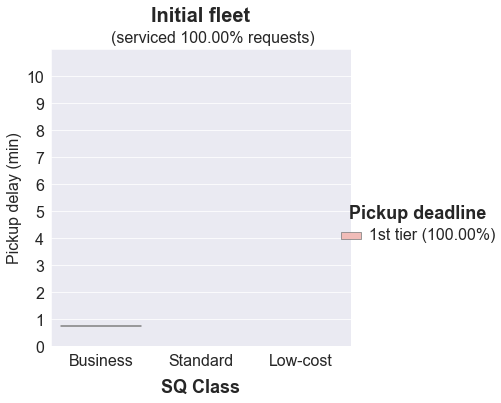

In [4]:
# Get all instances in folder
instance_file_names = os.listdir(request_log_folder)


# Instance Info (key = instance name)
dic_all_instance_settings = dict()
dic_all_round_track = dict()
dic_all_request_track = dict()

print("Reading files in folder:", request_log_folder)
for file_name in instance_file_names:
    instance, extension = file_name.split(".")
    print("  - Processing", instance)
    experiment_file= "{}request_track/{}.csv".format(instances_folder, instance)
    df_user_track = pd.read_csv(experiment_file,  parse_dates = True, comment = "#")
    violin(df_user_track, violin_log_folder, instance, replace=True)